In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from matplotlib.image import imread
import numpy as np
from PIL import Image
import cv2 
import os 
import glob 
from numpy.linalg import eig
from numpy import array
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from numpy import linalg as LA


In [3]:

images = []
for filename in sorted(os.listdir("/content/drive/MyDrive/ORL")):
    img = cv2.imread(os.path.join("/content/drive/MyDrive/ORL",filename),cv2.IMREAD_GRAYSCALE)
    if img is not None:
       ar=img.flatten()
     
       images.append(ar)
#images  
data =np.array(images)
data


array([[ 34,  34,  33, ...,  37,  40,  33],
       [ 42,  41,  44, ...,  42,  43,  41],
       [ 48,  49,  45, ...,  47,  46,  46],
       ...,
       [113, 112, 111, ...,  87,  87,  89],
       [112, 109, 116, ...,  93,  88,  92],
       [111, 114, 112, ...,  88,  86,  92]], dtype=uint8)

In [4]:
vec=np.empty([400,1])
count=0;
for i in range(0,400):
  if (i%10==0):
    count+=1
  vec[i]=count
  
DataLab=np.hstack((data,vec)) 



In [6]:
test=[]
train=[]
trainVec=np.empty([200,1])
testVec=np.empty([200,1])
k=0
l=0
for i in range(0,400):
  if (i%2==0):
    train.append(data[i])
    trainVec[k]=DataLab[i,10304]
    k+=1
  else:
    test.append(data[i])
    testVec[l]=DataLab[i,10304]
    l+=1
train=np.array(train)
test=np.array(test)
print(train.shape)
print(test.shape)
print(trainVec.shape)
print(testVec.shape)


(200, 10304)
(200, 10304)
(200, 1)
(200, 1)


**Classification Using LDA**

a. Use the pseudo code below for LDA. We will modify few lines in
pseudocode to handle multiclass LDA.
i. Calculate the mean vector for every class Mu1, Mu2, ..., Mu40.

In [21]:
#LDA-Mean
mean=[]
temp=[]
count=0
temp.append(train[0])
for i in range(1,200):
  if (i%5==0):
    mean.append(np.mean(temp,0))
    temp.clear()
    count+=1
  temp.append(train[i])
 
mean.append(np.mean(temp,0))

mean=np.array(mean)
print("mean : ")
print( mean)
mean.shape





mean : 
[[ 45.2  50.   51.6 ...  36.6  37.2  37. ]
 [134.4 130.6 132.8 ...  33.4  42.8  45.6]
 [ 47.   46.4  47.  ...  34.4  34.2  39. ]
 ...
 [ 56.4  56.4  57.2 ...  64.   65.4  66. ]
 [121.4 120.  120.4 ...  63.8  65.   64. ]
 [107.  107.2 110.  ...  84.6  76.8  84.2]]


(40, 10304)

ii. Replace B matrix by Sb.
Sb = ∑nk(μk − μ)(μk − μ)

In [8]:
#LDA Sb
overallMean=np.mean(train,0)
Sb=np.zeros((10304,10304))
temp=np.empty([10304,1])
for i in range(0,40):
  temp=np.subtract(mean[i].reshape(10304,1),overallMean.reshape(10304,1))
  temp=5*temp
  Sb=np.add(Sb,np.dot(temp,np.transpose(temp)))
print(Sb)
Sb.shape


[[1142059.775 1126678.55  1128001.55  ... -135810.725  -94167.375
   -55609.8  ]
 [1126678.55  1114231.1   1114159.1   ... -125802.45   -87799.75
   -51271.6  ]
 [1128001.55  1114159.1   1116797.1   ... -135117.45   -95739.75
   -57861.6  ]
 ...
 [-135810.725 -125802.45  -135117.45  ... 1499672.775 1461915.125
  1424656.2  ]
 [ -94167.375  -87799.75   -95739.75  ... 1461915.125 1482471.375
  1440093.   ]
 [ -55609.8    -51271.6    -57861.6   ... 1424656.2   1440093.
  1425113.6  ]]


(10304, 10304)

iii. S matrix remains the same, but it sums S1, S2, S3, ...S40.

In [9]:
#computing S total=s1+s2+s3+...
temp=[]
temp.append(train[0])
empty=[]
k=0
St=np.zeros((10304,10304))
Sk=[]
centered=[]
for i in range(1,200):
  if (i%5==0):
    centered=temp-np.transpose(mean[k])  
    temp.clear()
    k+=1
    Sk=np.dot(np.transpose(centered),centered)
    centered=np.array(empty)   
    St=np.add(St,Sk)
  temp.append(train[i])
centered=temp-np.transpose(mean[k]) 
temp.clear()
k+=1
Sk=np.dot(np.transpose(centered),centered)
centered=np.array(empty)
St=np.add(St,Sk)
St

array([[ 27906.4,  27124. ,  27227.2, ...,  -2136.8,    439. ,   6393. ],
       [ 27124. ,  28947.2,  28018.2, ...,  -2275.4,   1679. ,   6850.4],
       [ 27227.2,  28018.2,  29013.2, ...,  -2122.6,   1946. ,   6453.8],
       ...,
       [ -2136.8,  -2275.4,  -2122.6, ..., 140943.2,  80518. ,  50058.4],
       [   439. ,   1679. ,   1946. , ...,  80518. ,  88147.6,  64694.6],
       [  6393. ,   6850.4,   6453.8, ...,  50058.4,  64694.6,  90457.2]])

iv. Use 39 dominant eigenvectors instead of just one. You will
have a projection matrix U39x10304.

In [10]:
stInv=LA.inv(St)
arr=np.dot(stInv,Sb)




In [11]:
eigen_values, eigen_vectors =LA.eigh(arr)
print( eigen_values)
print(eigen_vectors)
w=np.real( np.delete(eigen_vectors, np.s_[0:10265], axis=1)   )
print(w)




[-1.17110431e+20 -6.76695942e+19 -3.35468434e+19 ...  3.34735812e+19
  6.88736151e+19  1.17166762e+20]
[[ 0.00749915  0.02206207 -0.00510459 ...  0.00399988 -0.02138271
  -0.0076256 ]
 [ 0.00725071  0.02150676 -0.00527283 ...  0.00425681 -0.02100036
  -0.00740412]
 [ 0.00725951  0.02171366 -0.00565604 ...  0.00452652 -0.0209604
  -0.00736247]
 ...
 [ 0.01025344  0.01014426  0.0138784  ...  0.01312411  0.01017303
   0.01035137]
 [ 0.00283254 -0.00469117  0.00399483 ...  0.00362798 -0.00469939
   0.00286593]
 [-0.00888707 -0.0014774  -0.0181001  ... -0.01739702 -0.00150572
  -0.00901349]]
[[-0.01825479  0.01920133 -0.00622078 ...  0.00399988 -0.02138271
  -0.0076256 ]
 [-0.01913118  0.0207947  -0.00611337 ...  0.00425681 -0.02100036
  -0.00740412]
 [-0.0156959   0.01781786 -0.00469754 ...  0.00452652 -0.0209604
  -0.00736247]
 ...
 [ 0.00970229 -0.00199065 -0.03052509 ...  0.01312411  0.01017303
   0.01035137]
 [-0.0046861   0.00321522  0.00900207 ...  0.00362798 -0.00469939
   0.0028659

b. Project the training set, and test sets separately using the same
projection matrix U. You will have 39 dimensions in the new space.

In [12]:

trainRed=np.zeros((200,39))
testRed=np.zeros((200,39))
trainRed=np.dot(train,w)
testRed=np.dot(test,w)




c. Use a simple classifier (first Nearest Neighbor to determine the class
labels).

In [13]:
nas=np.transpose(trainVec)

classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(trainRed, trainVec.ravel())  
test_predict = classifier.predict(testRed)   
true_predicted_count=0
for j in range(0,200):
   if test_predict[j] ==testVec[j]:
      true_predicted_count+=1

true_predicted_count

190

In [14]:
accuracy=true_predicted_count/200
accuracy=accuracy*100
accuracy

95.0

Report Accuracy for the Multiclass LDA on the face recognition
dataset.

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(trainRed)

train_pca3 = scaler.transform(trainRed)
test_pca3 = scaler.transform(testRed)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(trainRed, trainVec)

y_pred = classifier.predict(testRed)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(testVec, y_pred))
print(classification_report(testVec, y_pred))

[[5 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         5
         2.0       1.00      1.00      1.00         5
         3.0       0.83      1.00      0.91         5
         4.0       1.00      1.00      1.00         5
         5.0       0.83      1.00      0.91         5
         6.0       1.00      1.00      1.00         5
         7.0       0.62      1.00      0.77         5
         8.0       1.00      0.60      0.75         5
         9.0       1.00      1.00      1.00         5
        10.0       1.00      1.00      1.00         5
        11.0       1.00      0.80      0.89         5
        12.0       1.00      1.00      1.00         5
        13.0       1.00      1.00      1.00         5
        14.0       1.00      1.00      1.00         5
        15.0       1.00      1.00      1.00         5
        16.0   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


 **Classifier Tuning (LDA)**

In [22]:
acc=[]
ks=[]
for i in range(1, 8,2):
  ks.append(i)
  classifier = KNeighborsClassifier(n_neighbors=i)
  classifier.fit(trainRed, trainVec.ravel())  
  test_predict = classifier.predict(testRed)   
  true_predicted_count=0
  for j in range(0,200):
     if test_predict[j] ==testVec[j]:
       true_predicted_count+=1
  accuracy=true_predicted_count/200
  accuracy=accuracy*100
  print("at k = ",i,", accuracy = ", accuracy)
  acc.append((true_predicted_count/200)*100)
  
    

at k =  1 , accuracy =  95.0
at k =  3 , accuracy =  88.0
at k =  5 , accuracy =  79.5
at k =  7 , accuracy =  76.5


Text(0, 0.5, 'accuracy')

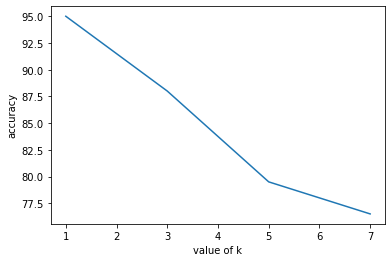

In [23]:
plt.plot(ks, acc)
plt.xlabel('value of k')
plt.ylabel('accuracy')  


**Compare vs Non-Face Images**

a. Download non-face images and make them of the same size 92x112.
and try to solve the classification problem faces vs. Non-faces.

In [13]:
images = []
for filename in sorted(os.listdir("/content/drive/MyDrive/NonFaces")):
    img = cv2.imread(os.path.join("/content/drive/MyDrive/NonFaces",filename),cv2.IMREAD_GRAYSCALE)
    img=cv2.resize(img, (92,112), interpolation = cv2.INTER_AREA)
    if img is not None:
       ar=img.flatten()
     
       images.append(ar)
#images  
data =np.array(images)
data

array([[ 34,  34,  33, ...,  37,  40,  33],
       [ 42,  41,  44, ...,  42,  43,  41],
       [ 48,  49,  45, ...,  47,  46,  46],
       ...,
       [ 84,  83,  81, ..., 106, 102, 107],
       [104, 107, 104, ..., 117, 123, 116],
       [131, 137, 130, ..., 146, 148, 153]], dtype=uint8)

In [14]:
vec=np.empty([400,1])
count=0;
for i in range(0,200):
  
  vec[i]=0

i=0
for i in range(200,400):
  
  vec[i]=1 
print(vec.shape)  
DataLab=np.hstack((data,vec)) 
DataLab


(400, 1)


array([[ 34.,  34.,  33., ...,  40.,  33.,   0.],
       [ 42.,  41.,  44., ...,  43.,  41.,   0.],
       [ 48.,  49.,  45., ...,  46.,  46.,   0.],
       ...,
       [ 84.,  83.,  81., ..., 102., 107.,   1.],
       [104., 107., 104., ..., 123., 116.,   1.],
       [131., 137., 130., ..., 148., 153.,   1.]])

In [15]:
test=[]
train=[]
trainVec=np.empty([200,1])
testVec=np.empty([200,1])
k=0
l=0
for i in range(0,400):
  if (i%2==0):
    train.append(data[i])
    trainVec[k]=DataLab[i,10304]
    k+=1
  else:
    test.append(data[i])
    testVec[l]=DataLab[i,10304]
    l+=1
train=np.array(train)
test=np.array(test)
print(train.shape)
print(test.shape)
print(trainVec.shape)
print(testVec.shape)

(200, 10304)
(200, 10304)
(200, 1)
(200, 1)


In [16]:
mean1=[]
mean2=[]
temp=[]
count=0
temp.append(train[0])
for i in range(1,200):
  if (i%100==0):
    mean1.append(np.mean(temp,0))
    temp.clear()
    count+=1
  temp.append(train[i])
 
mean2.append(np.mean(temp,0))
mean1=np.array(mean1)
mean1=np.transpose(mean1)
mean2=np.array(mean2)
mean2=np.transpose(mean2)
print(mean1.shape)
print(mean2.shape)





(10304, 1)
(10304, 1)


In [17]:
B2=np.dot((mean1-mean2),(mean1-mean2).T)
print(B2)
print(B2.shape)


[[2698.8025 2614.6435 2478.015  ... 3001.1515 3089.4665 3274.928 ]
 [2614.6435 2533.1089 2400.741  ... 2907.5641 2993.1251 3172.8032]
 [2478.015  2400.741  2275.29   ... 2755.629  2836.719  3007.008 ]
 ...
 [3001.1515 2907.5641 2755.629  ... 3337.3729 3435.5819 3641.8208]
 [3089.4665 2993.1251 2836.719  ... 3435.5819 3536.6809 3748.9888]
 [3274.928  3172.8032 3007.008  ... 3641.8208 3748.9888 3974.0416]]
(10304, 10304)


In [18]:
cent1=[]
cent2=[]
for i in range(0,100):
  
  cent1.append(train[i])


for i in range(100,200):
  
  cent2.append(train[i])
print(np.shape(cent1)) 
print(np.shape(cent2)) 

(100, 10304)
(100, 10304)


In [19]:

s1=np.dot(np.transpose(cent1),cent1)
s2=np.dot(np.transpose(cent2),cent2)
Stotal=np.add(s1,s2)
print(s1.shape)
print(s2.shape)
print(Stotal)
print(Stotal.shape)


(10304, 10304)
(10304, 10304)
[[221 246 117 ...   5  57  51]
 [246  93 227 ...  71 208 247]
 [117 227  92 ... 153  39 245]
 ...
 [  5  71 153 ...  83  57  69]
 [ 57 208  39 ...  57 157  53]
 [ 51 247 245 ...  69  53  20]]
(10304, 10304)


In [20]:
Sinv=LA.inv(Stotal)
arr=np.dot(Sinv,B2)


In [21]:
eigen_values, eigen_vectors =LA.eigh(arr)
print(eigen_values)
print(eigen_vectors)

[-749124.7120031  -247064.44450773 -157463.41877292 ...  157891.90235162
  252196.55193851  744465.20416754]
[[ 0.01321309 -0.01130974  0.01281123 ... -0.01385647  0.0109499
   0.01352341]
 [ 0.01280207 -0.01095969  0.01241641 ... -0.01341932  0.01060594
   0.01310065]
 [ 0.01213127 -0.01038226  0.01175918 ... -0.01272715  0.01005621
   0.01241795]
 ...
 [-0.01732195 -0.02009632 -0.01379435 ... -0.01331577 -0.02171429
   0.01751727]
 [ 0.01378787  0.0160197   0.01100983 ...  0.01055528  0.01723468
  -0.01392318]
 [-0.00652547 -0.00757802 -0.00520597 ... -0.00500249 -0.00816458
   0.0065927 ]]


How many dominant eigenvectors will you use for the LDA
solution?

**4 dominant eigen vectors are sufficient**

In [22]:
w=np.real( np.delete(eigen_vectors, np.s_[0:10300], axis=1)   )
print(w)
trainRed=np.zeros((200,4))
testRed=np.zeros((200,4))
trainRed=np.dot(train,w)
testRed=np.dot(test,w)

[[ 0.00714293 -0.01385647  0.0109499   0.01352341]
 [ 0.00691616 -0.01341932  0.01060594  0.01310065]
 [ 0.00656199 -0.01272715  0.01005621  0.01241795]
 ...
 [-0.02166711 -0.01331577 -0.02171429  0.01751727]
 [ 0.01714324  0.01055528  0.01723468 -0.01392318]
 [-0.00812985 -0.00500249 -0.00816458  0.0065927 ]]


In [23]:
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(trainRed, trainVec.ravel())  
test_predict = classifier.predict(testRed)   
true_predicted_count=0
for j in range(0,200):
   if test_predict[j] ==testVec[j]:
      true_predicted_count+=1

true_predicted_count

199

In [24]:
accuracy=true_predicted_count/200
accuracy=accuracy*100
accuracy

99.5

Show failure and success cases.

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(trainRed)

train_pca3 = scaler.transform(trainRed)
test_pca3 = scaler.transform(testRed)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(trainRed, trainVec)

y_pred = classifier.predict(testRed)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(testVec, y_pred))
print(classification_report(testVec, y_pred))

[[100   0]
 [  1  99]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       100
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


 Plot the accuracy vs the number of non-faces images while fixing
the number of face images.
number of non-faces images = 100

In [36]:
newData=np.delete(data,np.s_[300:400],axis=0)
newData.shape
vec=np.empty([300,1])
count=0;
for i in range(0,200):  
  vec[i]=0
i=0
for i in range(200,300):
  vec[i]=1 
print(vec.shape)  
DataLab=np.hstack((newData,vec)) 
DataLab
test=[]
train=[]
trainVec=np.empty([150,1])
testVec=np.empty([150,1])
k=0
l=0
for i in range(0,300):
  if (i%2==0):
    train.append(newData[i])
    trainVec[k]=DataLab[i,10304]
    k+=1
  else:
    test.append(newData[i])
    testVec[l]=DataLab[i,10304]
    l+=1
train=np.array(train)
test=np.array(test)
print(train.shape)
print(test.shape)
print(trainVec.shape)
print(testVec.shape)


(300, 1)
(150, 10304)
(150, 10304)
(150, 1)
(150, 1)


In [38]:
mean1=[]
mean2=[]
temp=[]
count=0
temp.append(train[0])
for i in range(1,150):
  if (i%100==0):
    mean1.append(np.mean(temp,0))
    temp.clear()
    count+=1
  temp.append(train[i])
mean2.append(np.mean(temp,0))
mean1=np.array(mean1)
mean1=np.transpose(mean1)
mean2=np.array(mean2)
mean2=np.transpose(mean2)
print(mean1.shape)
print(mean2.shape)
cent1=[]
cent2=[]
for i in range(0,100):
  cent1.append(train[i])
for i in range(100,150):
  cent2.append(train[i])
print(np.shape(cent1)) 
print(np.shape(cent2)) 
B2=np.dot((mean1-mean2),(mean1-mean2).T)
print(B2)
print(B2.shape)
s1=np.dot(np.transpose(cent1),cent1)
s2=np.dot(np.transpose(cent2),cent2)
Stotal=np.add(s1,s2)
print(s1.shape)
print(s2.shape)
print(Stotal)
print(Stotal.shape)


(10304, 1)
(10304, 1)
(100, 10304)
(50, 10304)
[[3118.1056 2963.4288 2818.8032 ... 2757.3792 2849.5152 3140.4416]
 [2963.4288 2816.4249 2678.9736 ... 2620.5966 2708.1621 2984.6568]
 [2818.8032 2678.9736 2548.2304 ... 2492.7024 2575.9944 2838.9952]
 ...
 [2757.3792 2620.5966 2492.7024 ... 2438.3844 2519.8614 2777.1312]
 [2849.5152 2708.1621 2575.9944 ... 2519.8614 2604.0609 2869.9272]
 [3140.4416 2984.6568 2838.9952 ... 2777.1312 2869.9272 3162.9376]]
(10304, 10304)
(10304, 10304)
(10304, 10304)
[[105 105 155 ...  92 177 115]
 [105 111  37 ...  99 147 167]
 [155  37 105 ... 138  65  38]
 ...
 [ 92  99 138 ... 158 242  98]
 [177 147  65 ... 242 133 129]
 [115 167  38 ...  98 129 136]]
(10304, 10304)


In [39]:
Sinv=LA.inv(Stotal)
arr=np.dot(Sinv,B2)

In [40]:
eigen_values, eigen_vectors =LA.eigh(arr)
print(eigen_values)
print(eigen_vectors)

[-199553.64192704  -67085.1180788   -40598.45635666 ...   40189.95663684
   67145.08088143  197730.77930194]
[[ 0.01401945  0.01082277 -0.01313357 ...  0.0123924  -0.01105855
   0.01420554]
 [ 0.01331887  0.0102741  -0.01245841 ...  0.01180021 -0.01052202
   0.01350611]
 [ 0.01267958  0.00979729 -0.01189972 ...  0.01117722 -0.00998336
   0.012836  ]
 ...
 [-0.00770324  0.00926817  0.00587265 ...  0.00614469  0.00893142
   0.00760314]
 [-0.00351121  0.00422344  0.00267546 ...  0.00280297  0.00407312
   0.00346648]
 [-0.0052959   0.00637069  0.00403603 ...  0.00422658  0.00614236
   0.00522798]]


In [41]:
w=np.real( np.delete(eigen_vectors, np.s_[0:10300], axis=1)   )
print(w)
trainRed=np.zeros((200,4))
testRed=np.zeros((200,4))
trainRed=np.dot(train,w)
testRed=np.dot(test,w)
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(trainRed, trainVec.ravel())  
test_predict = classifier.predict(testRed)   
true_predicted_count=0
for j in range(0,150):
   if test_predict[j] ==testVec[j]:
      true_predicted_count+=1

true_predicted_count

[[-0.00673307  0.0123924  -0.01105855  0.01420554]
 [-0.00641735  0.01180021 -0.01052202  0.01350611]
 [-0.00606595  0.01117722 -0.00998336  0.012836  ]
 ...
 [ 0.00954207  0.00614469  0.00893142  0.00760314]
 [ 0.0043541   0.00280297  0.00407312  0.00346648]
 [ 0.00656482  0.00422658  0.00614236  0.00522798]]


148

98.66666666666667


Text(0, 0.5, 'accuracy')

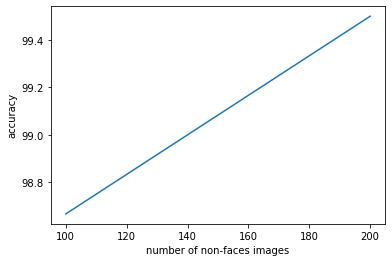

In [44]:
accuracy2=true_predicted_count/150
accuracy2=accuracy2*100
print(accuracy2)
accu=np.append(accuracy2,accuracy)
ImgNum=[100,200]
plt.plot(ImgNum, accu)
plt.xlabel('number of non-faces images')
plt.ylabel('accuracy')  

**Bonus**

In [3]:
images = []
for filename in sorted(os.listdir("/content/drive/MyDrive/ORL")):
    img = cv2.imread(os.path.join("/content/drive/MyDrive/ORL",filename),cv2.IMREAD_GRAYSCALE)
    if img is not None:
       ar=img.flatten()
     
       images.append(ar)
#images  
data =np.array(images)
data

array([[ 34,  34,  33, ...,  37,  40,  33],
       [ 42,  41,  44, ...,  42,  43,  41],
       [ 48,  49,  45, ...,  47,  46,  46],
       ...,
       [113, 112, 111, ...,  87,  87,  89],
       [112, 109, 116, ...,  93,  88,  92],
       [111, 114, 112, ...,  88,  86,  92]], dtype=uint8)

In [4]:
vec=np.empty([400,1])
count=0;
for i in range(0,400):
  if (i%10==0):
    count+=1
  vec[i]=count
  
DataLab=np.hstack((data,vec)) 
DataLab.shape


(400, 10305)

**Use different Training and Test splits. Change the number of
instances per subject to be 7 and keep 3 instances per subject for testing.**

In [5]:
test=[]
train=[]
trainVec=np.empty([160,1])
testVec=np.empty([120,1])
k=0
l=0
flag=0
counter1=7
counter2=0
for i in range(1,400):
  if (counter1>0 and flag ==0 ):
    if (i%2==0):
      test.append(data[i])
      testVec[l]=DataLab[i,10304]
      l+=1
    else :
      train.append(data[i]) 
      trainVec[k]=DataLab[i,10304]
      k+=1
    counter1-=1
    if (counter1==0):
      flag=1
    counter2=3
    continue
  if (counter2 > 0):
  
    
    counter2-=1
    if (counter2==0):
      flag=0
    counter1=7 
train=np.array(train)
test=np.array(test)
print(train.shape)
print(test.shape)
print(trainVec.shape)
print(testVec.shape)

(160, 10304)
(120, 10304)
(160, 1)
(120, 1)


In [6]:
mean=[]
temp=[]
count=0
temp.append(train[0])
for i in range(1,160):
  if (i%4==0):
    mean.append(np.mean(temp,0))
    temp.clear()
    count+=1
  temp.append(train[i])
 
mean.append(np.mean(temp,0))

mean=np.array(mean)
print(mean.shape)
mean


(40, 10304)


array([[ 52.  ,  51.  ,  45.5 , ...,  68.25,  60.  ,  67.  ],
       [136.5 , 135.  , 135.5 , ...,  20.25,  21.75,  31.5 ],
       [ 49.5 ,  47.75,  46.25, ...,  30.75,  30.5 ,  34.75],
       ...,
       [ 55.5 ,  54.  ,  55.  , ...,  64.5 ,  62.5 ,  61.25],
       [122.  , 120.  , 122.25, ...,  62.  ,  62.25,  60.  ],
       [109.25, 111.  , 110.75, ...,  84.  ,  83.5 ,  81.  ]])

In [7]:
overallMean=np.mean(train,0)

Sb=np.zeros((10304,10304))

temp=np.empty([10304,1])
for i in range(0,40):
  
  temp=np.subtract(mean[i].reshape(10304,1),overallMean.reshape(10304,1))
  temp=4*temp
  Sb=np.add(Sb,np.dot(temp,np.transpose(temp)))
 

Sb


array([[ 749103.6  ,  749524.4  ,  739583.4  , ..., -110906.8  ,
         -84074.8  ,  -61167.2  ],
       [ 749524.4  ,  752546.975,  741335.225, ..., -105461.2  ,
         -80509.95 ,  -57374.3  ],
       [ 739583.4  ,  741335.225,  732708.975, ..., -113118.2  ,
         -86204.45 ,  -65252.3  ],
       ...,
       [-110906.8  , -105461.2  , -113118.2  , ..., 1145148.4  ,
        1051155.4  , 1017728.6  ],
       [ -84074.8  ,  -80509.95 ,  -86204.45 , ..., 1051155.4  ,
         994803.9  ,  970391.6  ],
       [ -61167.2  ,  -57374.3  ,  -65252.3  , ..., 1017728.6  ,
         970391.6  ,  977766.4  ]])

In [8]:
#computing S total=s1+s2+s3+...
temp=[]
temp.append(train[0])
empty=[]
k=0
St=np.zeros((10304,10304))
Sk=[]
centered=[]
for i in range(1,160):
  if (i%4==0):
    centered=temp-np.transpose(mean[k])
    
    temp.clear()
    k+=1
    Sk=np.dot(np.transpose(centered),centered)
    centered=np.array(empty)
   
    
    St=np.add(St,Sk)
  temp.append(train[i])
centered=temp-np.transpose(mean[k])
 
temp.clear()
k+=1
Sk=np.dot(np.transpose(centered),centered)
centered=np.array(empty)
St=np.add(St,Sk)
St

array([[18664.5 , 17874.5 , 17934.75, ...,  1586.5 ,  -400.5 , -1731.  ],
       [17874.5 , 19410.25, 18666.25, ...,   824.75, -2017.75, -2338.  ],
       [17934.75, 18666.25, 20335.25, ...,  1293.5 ,  -826.75, -1593.75],
       ...,
       [ 1586.5 ,   824.75,  1293.5 , ..., 71872.5 , 56728.25, 51422.25],
       [ -400.5 , -2017.75,  -826.75, ..., 56728.25, 74410.  , 65149.25],
       [-1731.  , -2338.  , -1593.75, ..., 51422.25, 65149.25, 78901.5 ]])

In [9]:
stInv=LA.inv(St)
arr=np.dot(stInv,Sb)


In [10]:
eigen_values, eigen_vectors =LA.eigh(arr)
w=np.real( np.delete(eigen_vectors, np.s_[0:10265], axis=1)   )
print(w)
trainRed=np.zeros((160,39))
testRed=np.zeros((120,39))
trainRed=np.dot(train,w)
testRed=np.dot(test,w)

[[ 0.00239231 -0.00927234  0.00746086 ... -0.00296065  0.00176506
  -0.00194198]
 [ 0.00298689 -0.01148162  0.00994731 ... -0.00334391  0.00200062
  -0.00220199]
 [ 0.00241488 -0.00942156  0.00742204 ... -0.00287737  0.00171182
  -0.00187888]
 ...
 [-0.00563782 -0.00029528 -0.00695126 ... -0.00165264 -0.0015103
  -0.00242767]
 [ 0.00875538  0.00445979  0.00499052 ...  0.00396219  0.00348312
   0.00380923]
 [-0.00016156 -0.00325369  0.0013149  ... -0.00148604 -0.00086312
  -0.00124438]]


In [11]:
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(trainRed, trainVec.ravel())  
test_predict = classifier.predict(testRed)   
true_predicted_count=0
for j in range(0,120):
   if test_predict[j] ==testVec[j]:
      true_predicted_count+=1

true_predicted_count
accuracy=true_predicted_count/120
accuracy=accuracy*100
accuracy

91.66666666666666

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(trainRed)

train_pca3 = scaler.transform(trainRed)
test_pca3 = scaler.transform(testRed)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(trainRed, trainVec)

y_pred = classifier.predict(testRed)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(testVec, y_pred))
print(classification_report(testVec, y_pred))

[[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 1 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 3]]
              precision    recall  f1-score   support

         1.0       1.00      0.33      0.50         3
         2.0       1.00      0.67      0.80         3
         3.0       1.00      1.00      1.00         3
         4.0       1.00      1.00      1.00         3
         5.0       1.00      1.00      1.00         3
         6.0       1.00      1.00      1.00         3
         7.0       0.75      1.00      0.86         3
         8.0       0.75      1.00      0.86         3
         9.0       1.00      1.00      1.00         3
        10.0       0.75      1.00      0.86         3
        11.0       1.00      0.67      0.80         3
        12.0       0.75      1.00      0.86         3
        13.0       1.00      1.00      1.00         3
        14.0       0.75      1.00      0.86         3
        15.0       1.00      1.00      1.00         3
        16.0   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
